In [1]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [12]:
# load data
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=200):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*[!glasser]_connectivity_matrix.npy') #!glasser to exclude glasser matrices

    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 200 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=200)

# Now you can proceed with the visualization functions

Found 19 connectivity matrices


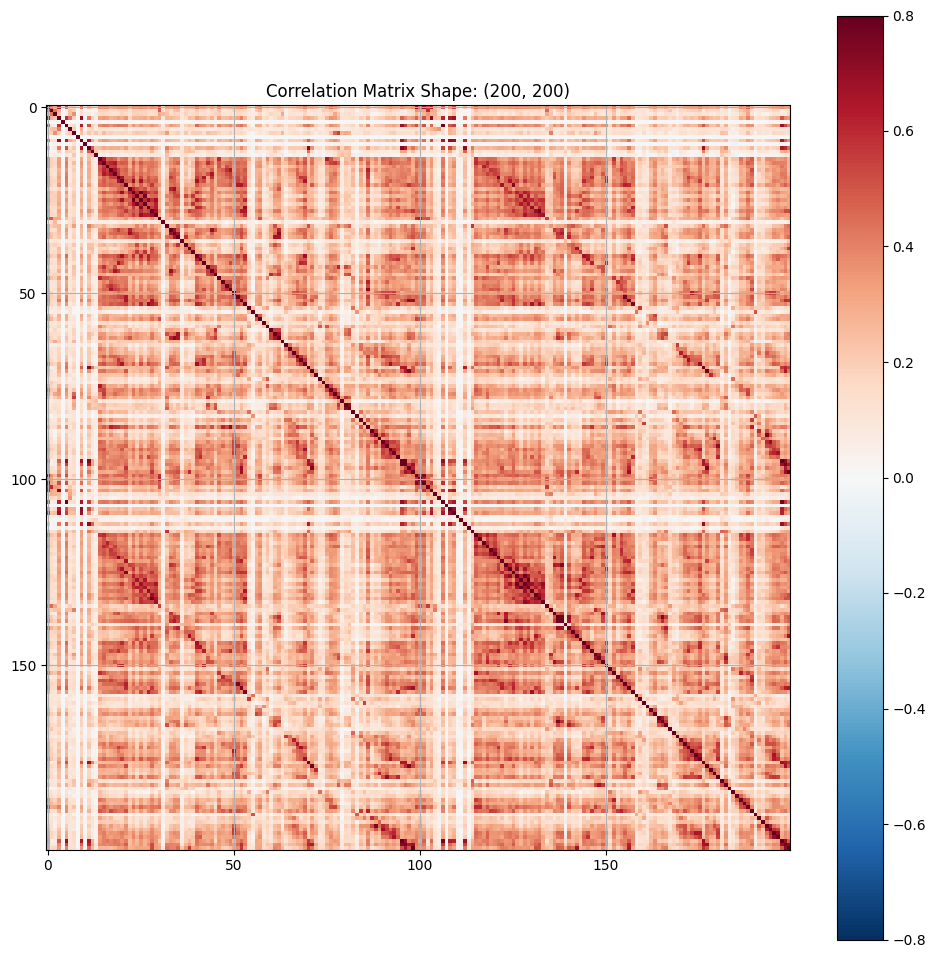


Connectivity Statistics:
Number of regions: 200
Total possible connections: 19900
Connections above 80th percentile threshold (0.366): 4080
Percentage of strong connections: 20.50%


<Figure size 1000x1000 with 0 Axes>

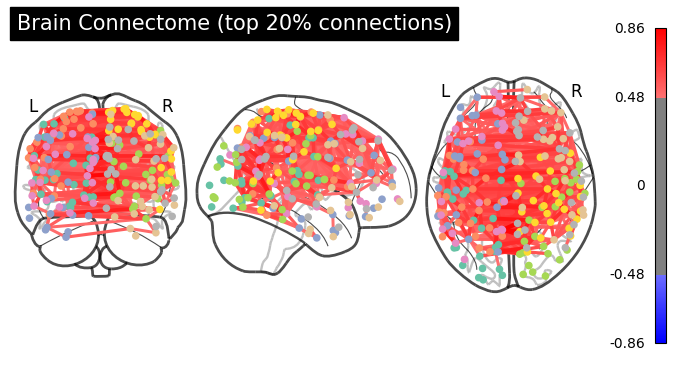

In [ ]:
#nilearn plotting
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

# Load the Schaefer atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
labels = [label.decode() if isinstance(label, bytes) else label for label in atlas.labels]

# Get the coordinates for each region
coords = plotting.find_parcellation_cut_coords(atlas.maps)

# Plot matrix dimensions with clear ticks
plt.figure(figsize=(12, 12))
plt.imshow(matrix, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
plt.colorbar()

# Add ticks every 50 positions
tick_spacing = 50
ticks = np.arange(0, matrix.shape[0], tick_spacing)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)

plt.title(f"Correlation Matrix Shape: {matrix.shape}")
plt.grid(True)
plt.show()

# Create connectome plot
plt.figure(figsize=(10, 10))
plotting.plot_connectome(
    matrix,
    coords,
    edge_threshold="80%",  # Keep top 20% of connections
    node_color='auto',
    node_size=20,
    title="Brain Connectome (top 20% connections)",
    colorbar=True
)

# Create an interactive visualization
view = plotting.view_connectome(
    matrix,
    coords,
    edge_threshold="80%",
    node_color='auto',
    node_size=20
)

# Open the interactive plot in a browser
view.open_in_browser()

# Print some statistics about the connectivity
total_connections = (len(matrix) * (len(matrix) - 1)) / 2  # Total possible connections
threshold = np.percentile(np.abs(matrix[np.triu_indices_from(matrix, k=1)]), 80)
strong_connections = np.sum(np.abs(matrix) > threshold) / 2  # Divide by 2 to not count connections twice

print(f"\nConnectivity Statistics:")
print(f"Number of regions: {len(matrix)}")
print(f"Total possible connections: {int(total_connections)}")
print(f"Connections above 80th percentile threshold ({threshold:.3f}): {int(strong_connections)}")
print(f"Percentage of strong connections: {(strong_connections/total_connections)*100:.2f}%")

plt.show()

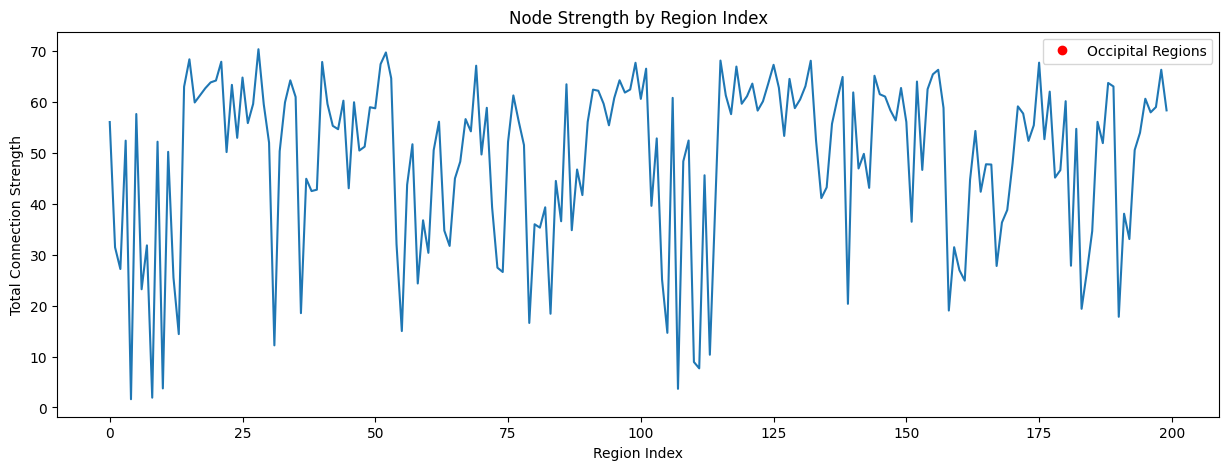

In [21]:
# Add regional connectivity strength analysis
node_strength = np.sum(np.abs(matrix), axis=0)

# Plot strength by region
plt.figure(figsize=(15, 5))
plt.plot(node_strength)
plt.title("Node Strength by Region Index")
plt.xlabel("Region Index")
plt.ylabel("Total Connection Strength")

# Add markers for occipital regions
plt.plot(occipital_indices, node_strength[occipital_indices], 'ro', label='Occipital Regions')
plt.legend()
plt.show()

Occipital connectivity stats:
Number of occipital regions: 0
Mean connectivity: nan
% of zero values: nan%
% of NaN values: nan%


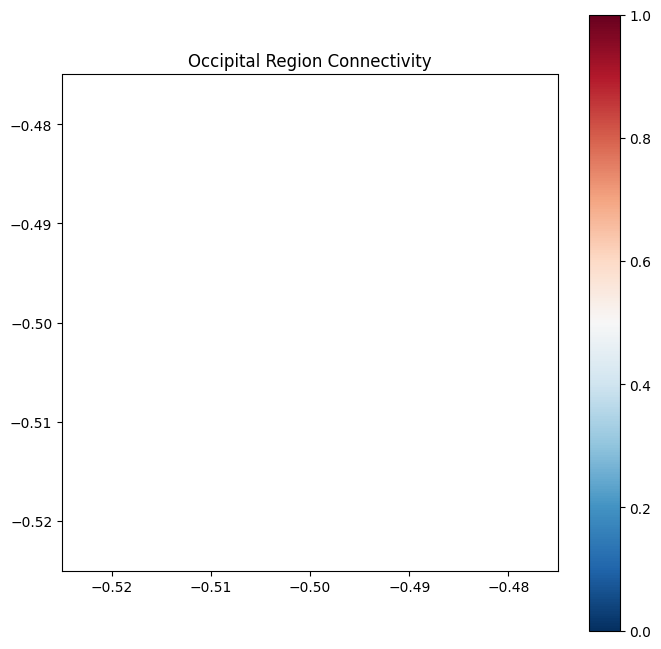

In [19]:
# Add these checks to your script
# Check for NaN or zero values in occipital regions
occipital_indices = [i for i, label in enumerate(labels) if 'Visual' in label]
occipital_connectivity = matrix[occipital_indices][:, occipital_indices]

print("Occipital connectivity stats:")
print(f"Number of occipital regions: {len(occipital_indices)}")
print(f"Mean connectivity: {np.mean(occipital_connectivity)}")
print(f"% of zero values: {np.sum(occipital_connectivity == 0) / occipital_connectivity.size * 100}%")
print(f"% of NaN values: {np.sum(np.isnan(occipital_connectivity)) / occipital_connectivity.size * 100}%")

# Visualize just the occipital subnetwork
plt.figure(figsize=(8, 8))
plt.imshow(occipital_connectivity, cmap='RdBu_r')
plt.title("Occipital Region Connectivity")
plt.colorbar()
plt.show()

In [23]:
# Print the first few labels to see their format
print("Sample of atlas labels:")
for i, label in enumerate(labels[:10]):
    print(f"{i}: {label}")

# Print unique network names in the labels
unique_networks = set()
for label in labels:
    # Split the label and add the network name
    parts = label.split('_')
    if len(parts) > 1:
        unique_networks.add(parts[1])  # Usually network name is the second part

print("\nUnique networks found in labels:")
for network in sorted(unique_networks):
    print(network)

# Count regions per network
network_counts = {}
for label in labels:
    parts = label.split('_')
    if len(parts) > 1:
        network = parts[1]
        network_counts[network] = network_counts.get(network, 0) + 1

print("\nNumber of regions per network:")
for network, count in network_counts.items():
    print(f"{network}: {count} regions")

Sample of atlas labels:
0: 7Networks_LH_Vis_1
1: 7Networks_LH_Vis_2
2: 7Networks_LH_Vis_3
3: 7Networks_LH_Vis_4
4: 7Networks_LH_Vis_5
5: 7Networks_LH_Vis_6
6: 7Networks_LH_Vis_7
7: 7Networks_LH_Vis_8
8: 7Networks_LH_Vis_9
9: 7Networks_LH_Vis_10

Unique networks found in labels:
LH
RH

Number of regions per network:
LH: 100 regions
RH: 100 regions


In [29]:
# Check if your functional data and atlas are in the same space
from nilearn import image

# Get affine matrices
func_affine = your_func_img.affine
atlas_affine = atlas.maps.affine

# Print affine matrices to compare
print("Functional data affine:")
print(func_affine)
print("\nAtlas affine:")
print(atlas_affine)

# Check image dimensions
print("\nDimensions:")
print(f"Functional data: {your_func_img.shape}")
print(f"Atlas: {atlas.maps.shape}")

NameError: name 'your_func_img' is not defined


Number of visual regions found: 29

Visual region labels:
7Networks_LH_Vis_1
7Networks_LH_Vis_2
7Networks_LH_Vis_3
7Networks_LH_Vis_4
7Networks_LH_Vis_5
7Networks_LH_Vis_6
7Networks_LH_Vis_7
7Networks_LH_Vis_8
7Networks_LH_Vis_9
7Networks_LH_Vis_10
7Networks_LH_Vis_11
7Networks_LH_Vis_12
7Networks_LH_Vis_13
7Networks_LH_Vis_14
7Networks_RH_Vis_1
7Networks_RH_Vis_2
7Networks_RH_Vis_3
7Networks_RH_Vis_4
7Networks_RH_Vis_5
7Networks_RH_Vis_6
7Networks_RH_Vis_7
7Networks_RH_Vis_8
7Networks_RH_Vis_9
7Networks_RH_Vis_10
7Networks_RH_Vis_11
7Networks_RH_Vis_12
7Networks_RH_Vis_13
7Networks_RH_Vis_14
7Networks_RH_Vis_15

Visual network connectivity stats:
Mean connectivity: 0.201
Min connectivity: -0.041
Max connectivity: 1.000


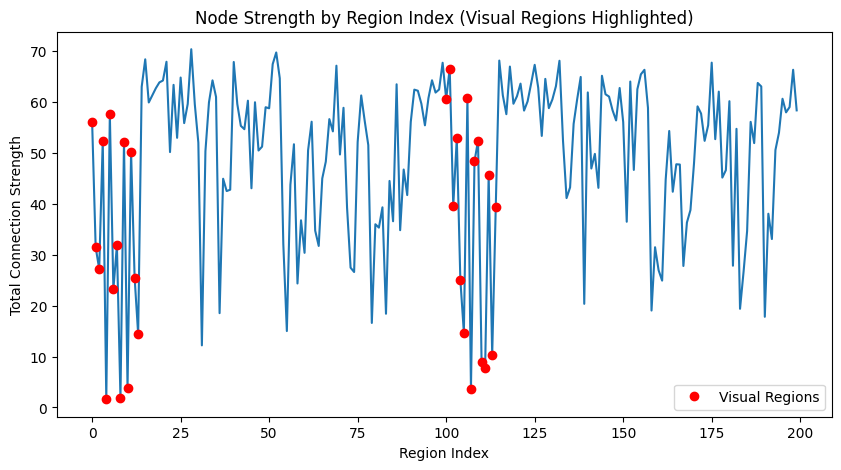

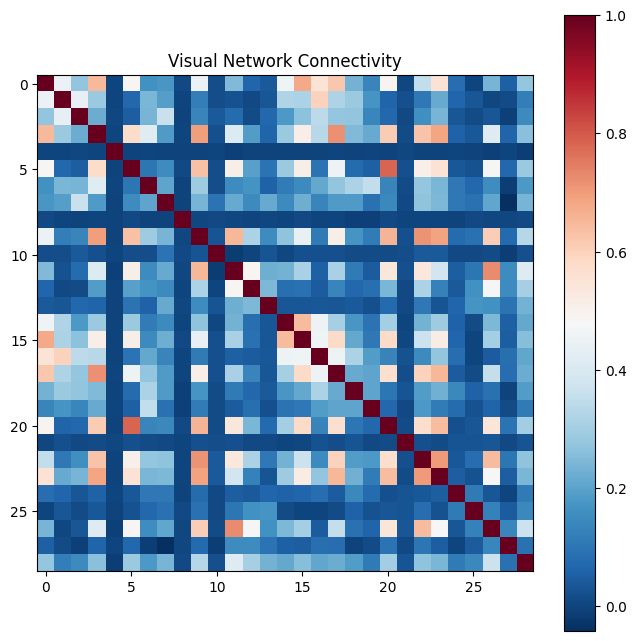

In [24]:
# Correct identification of visual regions
occipital_indices = [i for i, label in enumerate(labels) if '_Vis_' in label]
print(f"\nNumber of visual regions found: {len(occipital_indices)}")

# Print the actual visual region labels to verify
print("\nVisual region labels:")
for idx in occipital_indices:
    print(f"{labels[idx]}")

# Calculate connectivity stats for visual regions
if len(occipital_indices) > 0:
    occipital_connectivity = matrix[occipital_indices][:, occipital_indices]
    print("\nVisual network connectivity stats:")
    print(f"Mean connectivity: {np.mean(occipital_connectivity):.3f}")
    print(f"Min connectivity: {np.min(occipital_connectivity):.3f}")
    print(f"Max connectivity: {np.max(occipital_connectivity):.3f}")
    
    # Plot node strength specifically for visual regions
    plt.figure(figsize=(10, 5))
    plt.plot(node_strength)
    plt.plot(occipital_indices, node_strength[occipital_indices], 'ro', label='Visual Regions')
    plt.title("Node Strength by Region Index (Visual Regions Highlighted)")
    plt.xlabel("Region Index")
    plt.ylabel("Total Connection Strength")
    plt.legend()
    plt.show()

    # Visualize the visual network connectivity matrix
    plt.figure(figsize=(8, 8))
    plt.imshow(occipital_connectivity, cmap='RdBu_r')
    plt.title("Visual Network Connectivity")
    plt.colorbar()
    plt.show()

In [26]:
# Calculate mean connectivity for each network
networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
for network in networks:
    network_indices = [i for i, label in enumerate(labels) if f'_{network}_' in label]
    if network_indices:
        network_connectivity = matrix[network_indices][:, network_indices]
        print(f"{network} network mean connectivity: {np.mean(network_connectivity):.3f}")

Vis network mean connectivity: 0.201
SomMot network mean connectivity: 0.465
DorsAttn network mean connectivity: 0.322
SalVentAttn network mean connectivity: 0.393
Limbic network mean connectivity: 0.260
Cont network mean connectivity: 0.297
Default network mean connectivity: 0.265
